In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr, norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import warnings
import re
from matplotlib.backends.backend_pdf import PdfPages

warnings.filterwarnings('ignore')

In [31]:
# loading and preprocess time series data for COHA
def load_ts_df(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.groupby(['words', 'year', 'property'])[['outputs_z', 'count']].mean().reset_index()
    return df[df['count'] >= 50]

ts_df = load_ts_df('./data/SWOW_prediction/eval/time_series/ts_df.csv')

In [32]:
category_norms = pd.read_csv('./data/Referential version_Item level data.csv')
category_norms = category_norms.loc[category_norms['prod.freq'] > 1]
category_norms.groupby('category')['category.member'].count().to_dict()


{'academic subject': 41,
 'alcoholic drink': 30,
 'animal': 69,
 'art form': 16,
 'artistic movement': 9,
 'bathroom fixture': 19,
 'bird': 38,
 'bird of prey': 8,
 'boat': 16,
 'body of water': 15,
 'book genre': 22,
 'breed of dog': 36,
 'building': 34,
 'building material': 18,
 'camping equipment': 25,
 "carpenter's tool": 16,
 'chemical element': 35,
 'citrus fruit': 11,
 'clothing': 47,
 'colour': 24,
 'cosmetic': 23,
 'crime': 25,
 'dairy product': 11,
 'day of the week': 7,
 'disease': 24,
 'drug': 24,
 'emotion': 27,
 'fabric': 15,
 'family relationship': 42,
 'farm animal': 18,
 'fish': 26,
 'flower': 18,
 'four-legged animal': 38,
 'four-wheeled vehicle': 13,
 'fraction': 24,
 'fruit': 40,
 'fuel': 14,
 'furniture': 24,
 'gardening tool': 18,
 'gemstone': 12,
 'geometric shape': 17,
 'green vegetable': 19,
 'hair colour': 18,
 'hat': 17,
 'healthcare profession': 23,
 'herb': 16,
 'human dwelling': 18,
 'infectious disease': 14,
 'injury': 20,
 'insect': 27,
 'jewellery': 14

In [33]:
all_words = set(category_norms['category.member'])
ts_df = ts_df.loc[ts_df.words.isin(all_words)]
norms = category_norms.groupby('category')['category.member'].apply(list).to_dict()
print(len(norms)) #117 categories in total

117


In [34]:
category_df = pd.DataFrame()
for category in norms:
    words = norms[category]
    c_df = ts_df.loc[ts_df.words.isin(words)]
    c_df['category'] = category
    category_df = pd.concat((category_df, c_df), ignore_index = True)
    
rel_df = category_df.loc[category_df.property == 'previous_link']
pol_df = category_df.loc[category_df.property == 'polarity']


In [35]:
rel_df.sample() #moral relevance of words in different categories

,words,year,property,outputs_z,count,category
2885,sketch,1930,previous_link,-1.464228,379.0,art form


In [36]:
pol_df.sample()#moral polarity of words in different categories

,words,year,property,outputs_z,count,category
13398,rat,1960,polarity,-1.80031,712.0,four-legged animal


In [37]:

joint_category_rel = rel_df.groupby(['year','category']).outputs_z.mean().reset_index().set_index(['year','category']).\
join(\
rel_df.groupby(['year','category']).outputs_z.std().reset_index().set_index(['year','category']),\
lsuffix='_mean',rsuffix = '_std').reset_index()

In [38]:
len(rel_df.category.unique()), len(pol_df.category.unique())

(117, 117)

## Studying the rate of moralization in different conceptual categories

In [39]:
def get_growth_rate_word(category, df):
    """
    Compute the linear growth rate of moral relevance (outputs_z) for each word in a category.

    Parameters:
        category (str): The target category.
        df (pd.DataFrame): DataFrame with columns ['category', 'words', 'year', 'outputs_z'].

    Returns:
        pd.DataFrame: Word-level regression stats for the given category.
    """
    c_df = df[df.category == category]
    if c_df.empty:
        return pd.DataFrame()

    list_rows = []

    for word in c_df.words.unique():
        w_df = c_df[c_df.words == word].copy()
        if w_df.empty:
            continue

        agg_moral_relevance = w_df.outputs_z.mean()
        is_moral = agg_moral_relevance > 0

        # Normalize year for regression
        min_year = w_df.year.min()
        w_df['year'] = (w_df['year'] - min_year + 1) / 10

        model = smf.ols('outputs_z ~ year', data=w_df).fit()
        list_rows.append({
            'category': category,
            'word': word,
            'r2': model.rsquared,
            'n': len(w_df),
            'fpvalue': model.f_pvalue,
            'intercept_coef': model.params.get('Intercept', np.nan),
            'year_pvalue': model.pvalues.get('year', np.nan),
            'year_coef': model.params.get('year', np.nan),
            'is_moral': is_moral,
            'moral_relevance': agg_moral_relevance
        })

    return pd.DataFrame(list_rows)


def get_growth_rate(category, df):
    """
    Perform linear regression over average moral relevance for a given category.

    Parameters:
        category (str): The target category.
        df (pd.DataFrame): DataFrame with columns ['category', 'year', 'outputs_z'].

    Returns:
        dict: Regression results and moral relevance summary.
    """
    c_df = df[df.category == category].copy()
    if c_df.empty:
        return {}

    # Mean moral relevance in the final year
    last_year_value = c_df[c_df.year == 2000].outputs_z.mean()

    # Aggregate by year
    yearly_df = c_df.groupby('year')['outputs_z'].mean().reset_index()
    agg_moral_relevance = yearly_df.outputs_z.mean()
    is_moral = agg_moral_relevance > 0

    # Normalize year
    min_year = yearly_df.year.min()
    yearly_df['year'] = (yearly_df['year'] - min_year + 1) / 10

    model = smf.ols('outputs_z ~ year', data=yearly_df).fit()

    return {
        'category': category,
        'r2': model.rsquared,
        'n': len(yearly_df),
        'fpvalue': model.f_pvalue,
        'intercept_coef': model.params.get('Intercept', np.nan),
        'year_pvalue': model.pvalues.get('year', np.nan),
        'year_coef': model.params.get('year', np.nan),
        'is_moral': is_moral,
        'moral_relevance': agg_moral_relevance,
        'final_moral_relevance': last_year_value
    }


def plot_reg(category, df):
    """
    Plot the regression and time series trend of moral relevance for a category.

    Parameters:
        category (str): The category to visualize.
        df (pd.DataFrame): DataFrame with ['category', 'year', 'outputs_z'].
    """
    c_df = df[df.category == category].copy()
    if c_df.empty:
        print(f"No data for category: {category}")
        return

    yearly_df = c_df.groupby('year')['outputs_z'].mean().reset_index()
    min_year = yearly_df.year.min()
    yearly_df['log_year'] = yearly_df['year'] - min_year + 1

    model = smf.ols('outputs_z ~ log_year', data=yearly_df).fit()
    r2, coef = model.rsquared, model.params.get('log_year', 0)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Regression view
    sns.regplot(data=yearly_df, x='log_year', y='outputs_z', ax=axes[0])
    axes[0].set_title(f"{category}\nR²: {r2:.3f}, Coef: {coef:.3f}")
    axes[0].set_xlabel("Relative Time")
    axes[0].set_ylabel("Moral Relevance")

    # Time series trend
    sns.lineplot(data=yearly_df, x='year', y='outputs_z', ax=axes[1])
    axes[1].set_title(category)
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Moral Relevance")

    sns.despine()
    plt.tight_layout()
    plt.show()


In [65]:
def get_growth_result():
    reg = []
    for c in norms:
        result = get_growth_rate(c, rel_df)
        if len(result) == 0:
            continue
        reg.append(result)
    reg = pd.DataFrame(reg)

    coef = reg.groupby('category').year_coef.mean().to_dict()
    r2 = reg.groupby('category').r2.mean().to_dict()
    return reg, coef, r2

reg, coef, r2 = get_growth_result()
        

In [66]:
reg

,category,r2,n,fpvalue,intercept_coef,year_pvalue,year_coef,is_moral,moral_relevance,final_moral_relevance
0,academic subject,0.747526,16,1.552550e-05,0.188326,1.552550e-05,-0.014912,True,0.074995,0.042862
1,alcoholic drink,0.809026,16,2.126897e-06,-0.661386,2.126897e-06,-0.011881,False,-0.751680,-0.802043
2,animal,0.105152,16,2.204541e-01,-0.678038,2.204541e-01,0.001747,False,-0.664762,-0.639410
3,art form,0.886088,16,5.494554e-08,-0.948935,5.494554e-08,-0.011417,False,-1.035701,-1.100291
4,artistic movement,0.012758,16,6.770453e-01,-1.021080,6.770453e-01,-0.001207,False,-1.030250,-0.901535
...,...,...,...,...,...,...,...,...,...,...
112,water sport,0.299059,13,5.311128e-02,-1.123662,5.311128e-02,-0.009372,False,-1.182996,-1.179340
113,weapon,0.699340,16,5.423248e-05,0.082738,5.423248e-05,0.016883,True,0.211047,0.246359
114,weather,0.574707,16,6.665873e-04,-0.930032,6.665873e-04,-0.004089,False,-0.961107,-0.969227
115,wind instrument,0.828397,16,9.958840e-07,-0.355988,9.958840e-07,-0.038857,False,-0.651301,-0.945741


## Visualizing rate of moralization


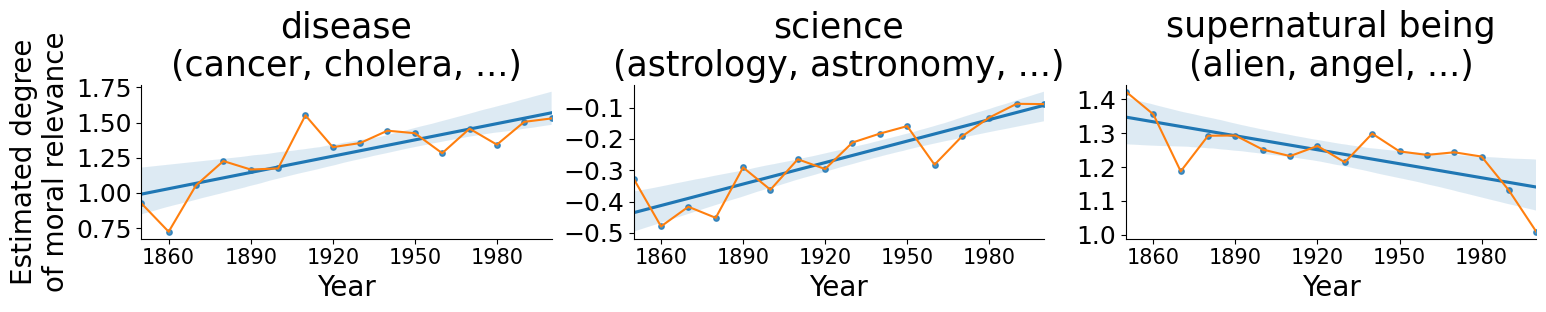

In [67]:
groups = ['disease','science','supernatural being']
fig,axes = plt.subplots(1, 3,figsize = (18, 2),sharey = False)
for i, ax in enumerate(axes):
    c = groups[i]
    r2_score = r2[c]
    coef_score = coef[c]
    
    plot_df = rel_df.loc[rel_df.category == c]
    plot_df_2 = plot_df.groupby('year').outputs_z.mean().reset_index()
    
    sns.regplot(data = plot_df_2, x = 'year', y = 'outputs_z',ax =ax, scatter_kws={'s':15})
    sns.lineplot(data = plot_df_2, x = 'year', y = 'outputs_z',ax =ax)
    ax.set_xlim(plot_df_2.year.min(), plot_df_2.year.max())
    c_terms = ", ".join(list(plot_df.loc[plot_df.category == c].words.unique())[:2]) + ', ...'
    ax.set_title(c + '\n(' + c_terms + ')', fontsize = 25)
    
    if i != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Estimated degree\nof moral relevance',fontsize = 20)
    ax.set_xlabel('Year',fontsize = 20)
   
    ax.set_xticks(np.arange(1860, 2010, 30),np.arange(1860, 2010, 30), fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 18)
sns.despine()

plt.show()


In [68]:
categories = list(reg.loc[(reg.r2 > 0.10)].sort_values(by = 'year_coef',ascending = False).head(50).category) #Visualizing top 50 categories with the highest growth rate

len(categories), categories

(50,
 ['hat',
  'disease',
  'violent crime',
  'breed of dog',
  'team sport',
  'infectious disease',
  'science',
  'non-violent crime',
  'snake',
  'two-dimensional shape',
  'crime',
  'unit of weight',
  'psychological illness',
  'sport',
  'rodent',
  'weapon',
  'two-wheeled vehicle',
  'four-wheeled vehicle',
  'vehicle',
  'insect',
  'political system',
  'geometric shape',
  'gemstone',
  'military title',
  'nut',
  'drug',
  'negative emotion',
  'part of a tree',
  'fruit',
  'fish',
  'part of the body',
  'unit of time',
  'stinging insect',
  'bird',
  'meat',
  'dairy product',
  'farm animal',
  'metal',
  'unit of length',
  'animal',
  'time of day',
  'body of water',
  'gardening tool',
  'symptom of illness',
  'prime number',
  'boat',
  'emotion',
  'season',
  'weather',
  'type of word'])

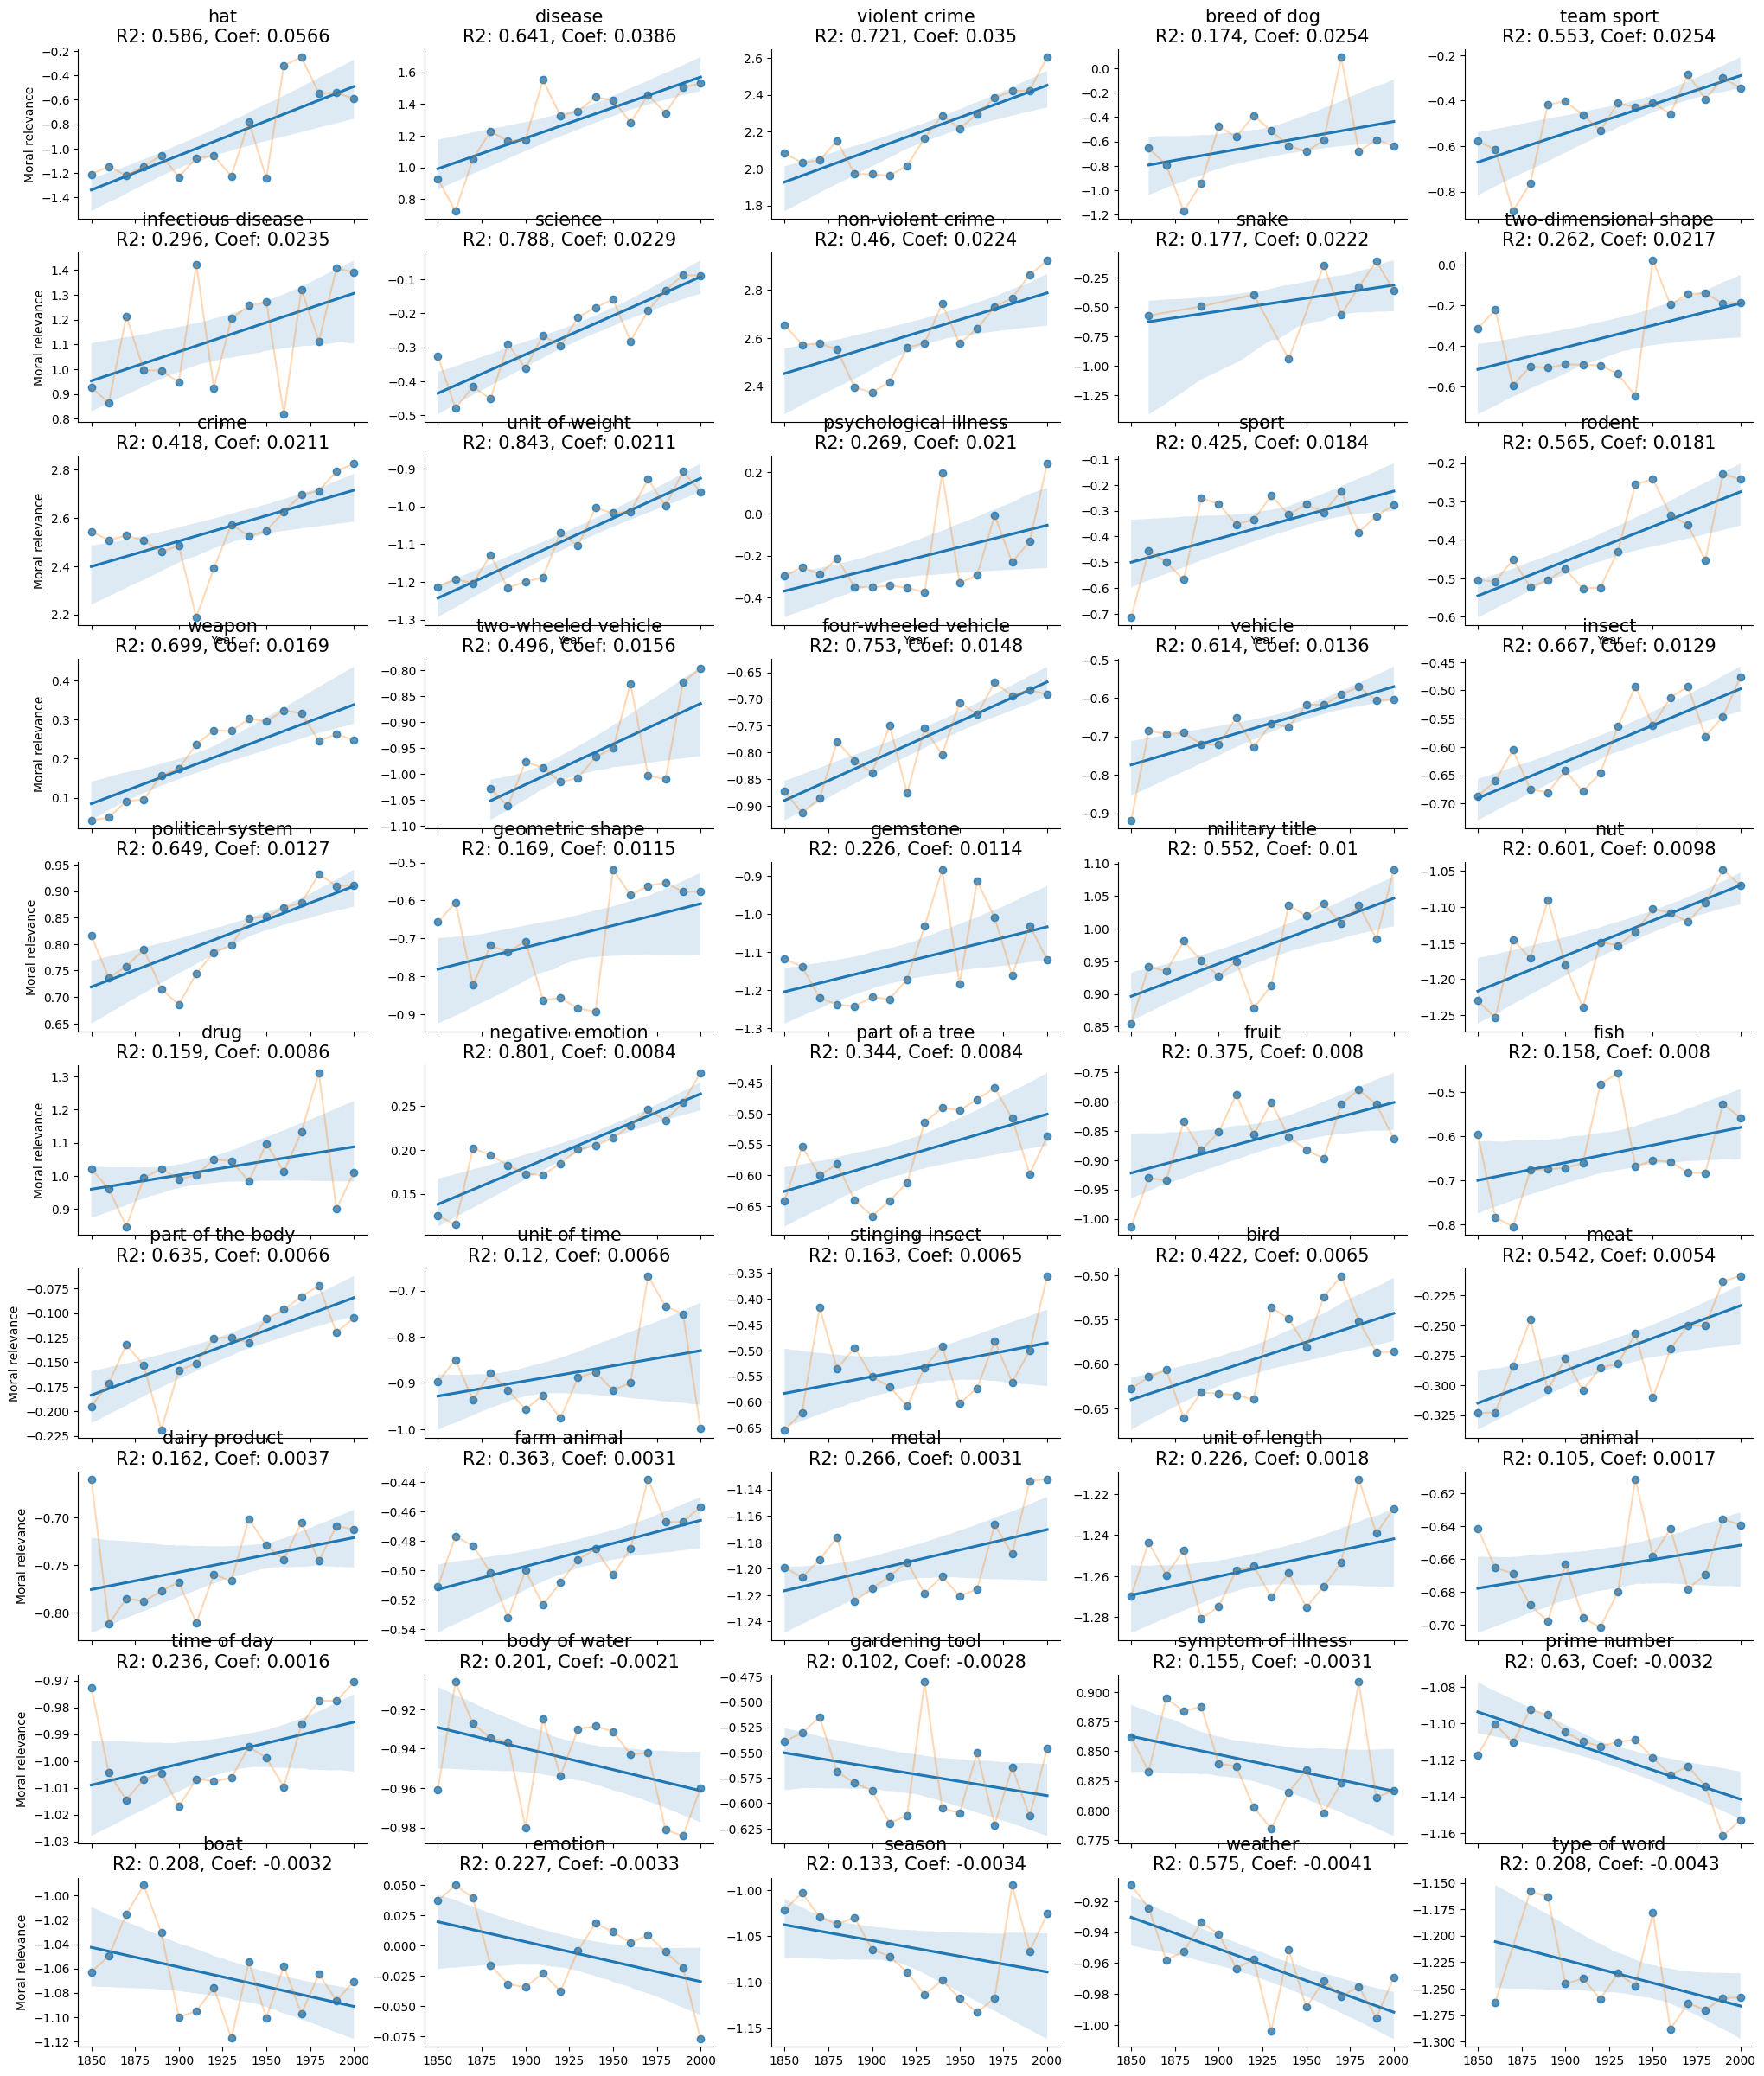

In [69]:
c_df = category_df.loc[category_df.category.isin(categories)]
c_df = c_df.loc[c_df.property == 'previous_link']
c_df['coef'] = c_df.category.apply(lambda c : coef[c])
c_df['r2'] = c_df.category.apply(lambda c : r2[c])

average_df = c_df.groupby(['year','category'])[['coef','r2','outputs_z']].mean().reset_index()

cluster_mapping = {c:", ".join(category_df.loc[category_df.property == 'previous_link'].\
                               loc[category_df.category == c].sample(7).words.unique()) for c in categories}
indices = [(i // 5, i % 5) for i in range(len(categories))]
fig,axes = plt.subplots(10, 5, figsize = (25, 30),sharex = True,sharey = False)
for i, c in enumerate(categories):
    
    r2_score = r2[c]
    coef_score = coef[c]
    row_index, col_index = indices[i]
    ax = axes[row_index][col_index]
    plot_df = c_df.loc[c_df.category == c]
    plot_df_2 = plot_df.groupby('year').outputs_z.mean().reset_index()
    
    sns.regplot(data = plot_df_2, x = 'year', y = 'outputs_z',ax =ax,)
    sns.lineplot(data = plot_df_2, x = 'year', y = 'outputs_z',ax =ax,alpha = 0.3)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.set_title(c +f'\nR2: {round(r2_score,3)}, Coef: {round(coef_score,4)}',fontsize = 15)
    if row_index == 2:
        ax.set_xlabel('Year')
    if col_index == 0:
        ax.set_ylabel('Moral relevance')
        
sns.despine()

## Comparing our framework with GPT4

In [70]:
swow_df = pd.read_csv('./data/SWOWEN/moralized_v1_all.csv')
swow_df.columns

Index(['cue', 'total', 'cue_mfd2', 'response_mfd1', 'cue_mfd1',
       'response_mfd2', 'cue_hte', 'response_hte', 'response_emotion',
       'cue_emotion', 'cue_moral', 'response_moral', 'link', 'pos',
       'previous_link', 'lower', 'is_synonym', 'degree'],
      dtype='object')

In [71]:
swow_df['cue'] = swow_df['cue'].apply(lambda c: c.strip().lower())
swow_relevance = swow_df.groupby('cue').previous_link.mean().to_dict()
gpt4_df = pd.read_csv('data/SWOWEN/gpt-4o_prediction_df_cat.csv')
gpt4_df['word'] = gpt4_df['word'].apply(lambda c: c.strip().lower())
gpt4_relevance = gpt4_df.groupby('word').gpt_score.mean().to_dict()
len(gpt4_relevance)


1967

In [72]:
rel_df['swow_relevance'] = rel_df.words.apply(lambda w: None if w not in swow_relevance\
                                                       else np.log(swow_relevance[w] * 100 + 1))
rel_df['gpt_relevance'] = rel_df.words.apply(lambda w: None if w not in gpt4_relevance\
                                                       else np.log(gpt4_relevance[w] * 100 + 1))

In [73]:
category_swow_relevance = rel_df[['category','words','swow_relevance']].dropna().\
groupby('category')[['swow_relevance']].mean().to_dict()
category_gpt_relevance = rel_df[['category','words','gpt_relevance']].dropna().\
groupby('category')[['gpt_relevance']].mean().to_dict()


In [74]:
reg['swow_relevance'] = reg['category'].apply(lambda c : category_swow_relevance['swow_relevance'][c])
reg['gpt_relevance'] = reg['category'].apply(lambda c : category_gpt_relevance['gpt_relevance'][c]
                                             if c in category_gpt_relevance['gpt_relevance'] else None)
reg.dropna()

,category,r2,n,fpvalue,intercept_coef,year_pvalue,year_coef,is_moral,moral_relevance,final_moral_relevance,swow_relevance,gpt_relevance
0,academic subject,0.747526,16,1.552550e-05,0.188326,1.552550e-05,-0.014912,True,0.074995,0.042862,0.879112,2.786485
1,alcoholic drink,0.809026,16,2.126897e-06,-0.661386,2.126897e-06,-0.011881,False,-0.751680,-0.802043,0.224454,2.734541
2,animal,0.105152,16,2.204541e-01,-0.678038,2.204541e-01,0.001747,False,-0.664762,-0.639410,0.465288,2.484928
3,art form,0.886088,16,5.494554e-08,-0.948935,5.494554e-08,-0.011417,False,-1.035701,-1.100291,0.179636,2.318282
4,artistic movement,0.012758,16,6.770453e-01,-1.021080,6.770453e-01,-0.001207,False,-1.030250,-0.901535,0.000000,2.555960
...,...,...,...,...,...,...,...,...,...,...,...,...
112,water sport,0.299059,13,5.311128e-02,-1.123662,5.311128e-02,-0.009372,False,-1.182996,-1.179340,0.000000,1.791759
113,weapon,0.699340,16,5.423248e-05,0.082738,5.423248e-05,0.016883,True,0.211047,0.246359,1.718627,2.943450
114,weather,0.574707,16,6.665873e-04,-0.930032,6.665873e-04,-0.004089,False,-0.961107,-0.969227,0.000000,1.918557
115,wind instrument,0.828397,16,9.958840e-07,-0.355988,9.958840e-07,-0.038857,False,-0.651301,-0.945741,0.000000,2.360012


## Evaluating our framework against empirical data from SWOW

In [77]:
import pingouin as pg

x = reg.moral_relevance
y = reg.swow_relevance
corr1 = pg.corr(x, y,method = 'spearman').round(3)
x = reg.gpt_relevance
corr2 = pg.corr(x, y,method = 'spearman').round(3)

errors1 = [corr1['CI95%'].values[0][0],corr1['CI95%'].values[0][1]] #Our framework against empirical data from SWOW

errors2 = [corr2['CI95%'].values[0][0],corr2['CI95%'].values[0][1]] #GPT-4 against empirical data from SWOW
bars1 = corr1['r'].values[0]
bars2 = corr2['r'].values[0]

errors1 = np.abs(np.array(errors1) - bars1)
errors2 = np.abs(np.array(errors2) - bars2)


In [78]:
corr1,corr2

(            n      r         CI95%  p-val  power
 spearman  117  0.744  [0.65, 0.82]    0.0    1.0,
             n      r         CI95%  p-val  power
 spearman  117  0.565  [0.43, 0.68]    0.0    1.0)

In [79]:
top_categories = rel_df.loc[rel_df.outputs_z > 1].category.unique() #Filtering 117 categories to only 52 with moral relevance > 1
len(top_categories)

52

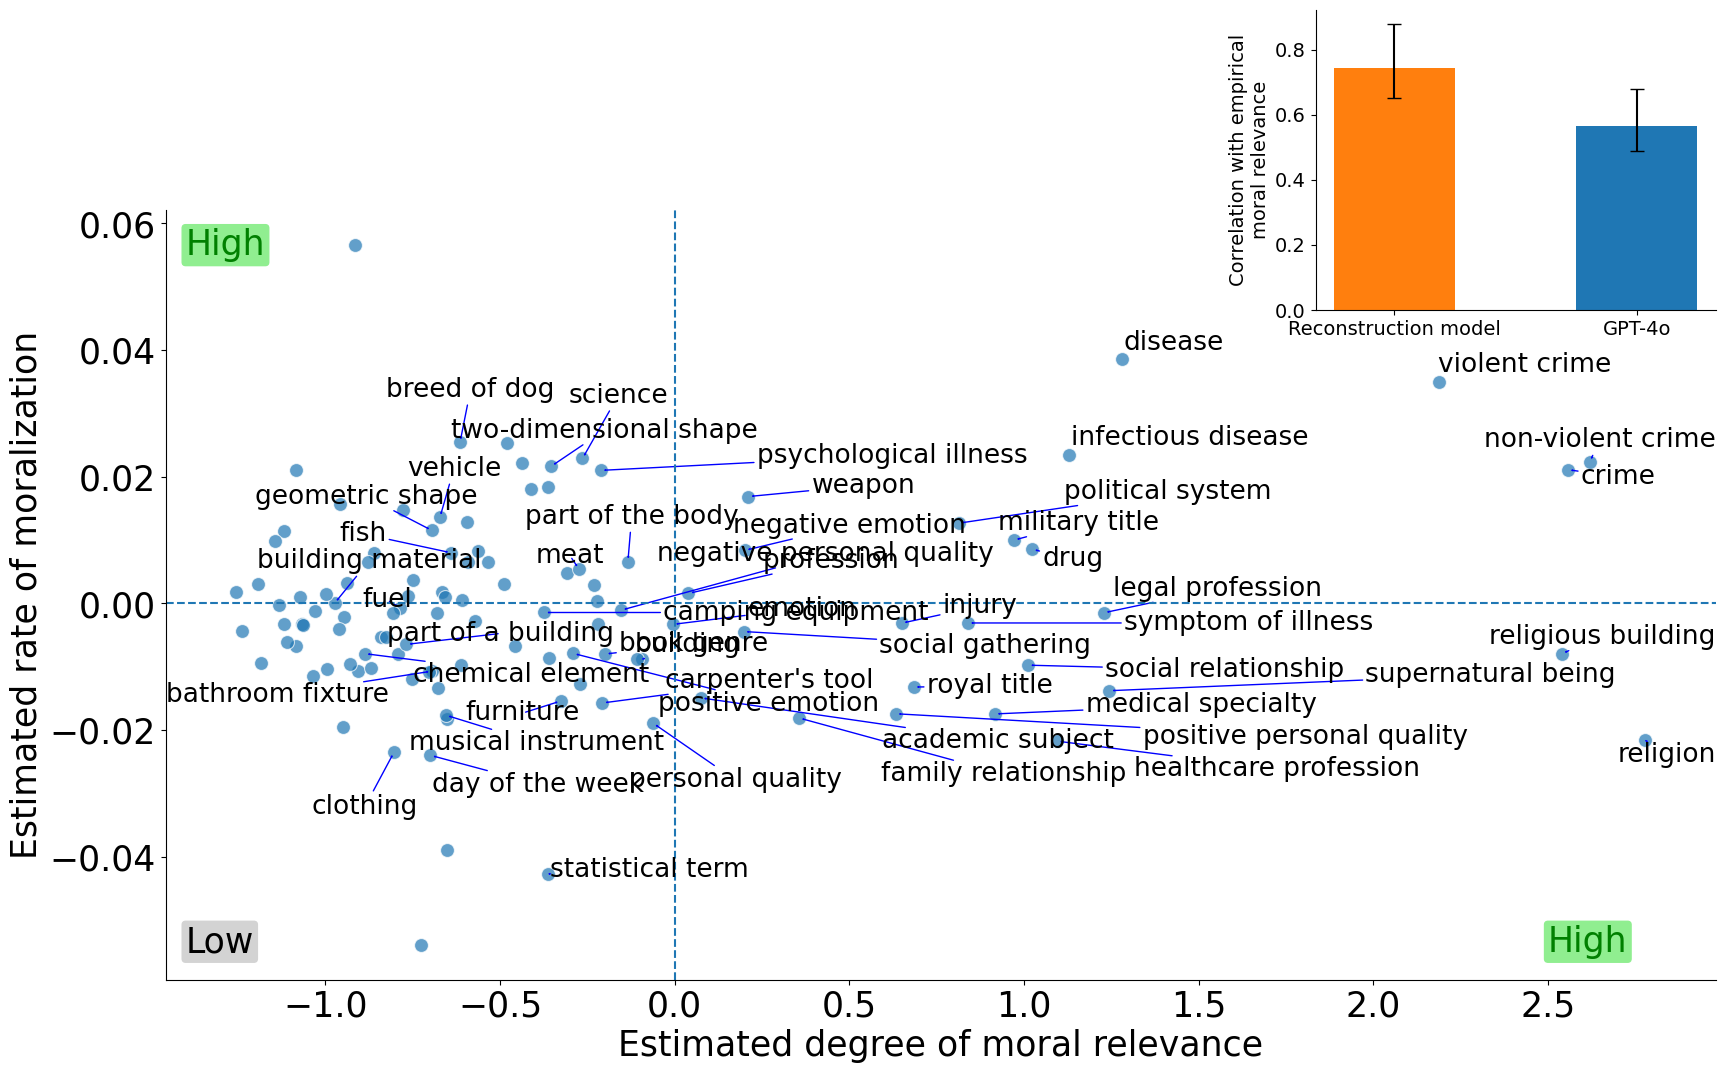

In [80]:
from adjustText import adjust_text

fig,ax = plt.subplots(figsize = (20, 10))
g = sns.scatterplot(data = reg, x = 'moral_relevance', y = 'year_coef',alpha = 0.7,
                   s = 100)
g.legend_ = None
groups = ['disease','science','supernatural being']
annotations = []
for i, row in reg.iterrows():
    if row['category'] not in top_categories:
        continue
    annotations.append(g.annotate(row['category'], (row['moral_relevance'], row['year_coef']),
                color = 'black',size = 19))
    
    
adjust_text(annotations,expand=(1, 1.2),arrowprops=dict(arrowstyle='->', color='blue'))
g.set_xlabel('Estimated degree of moral relevance',fontsize = 25)
g.set_ylabel('Estimated rate of moralization',fontsize = 25)

plt.axhline(y = 0,linestyle = '--')
plt.axvline(x= 0,linestyle = '--')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 25)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 25)
ax.text(x = -1.4, y = -0.055, s = 'Low', color = 'Black',fontsize = 25,
       bbox=dict(facecolor='lightgrey', edgecolor='lightgrey', boxstyle='round,pad=0.1'))

ax.text(x = -1.4, y = 0.055, s = 'High', color = 'Green',fontsize = 25,
       bbox=dict(facecolor='lightgreen', edgecolor='lightgreen', boxstyle='round,pad=0.1'))


ax.text(x = 2.5, y = -0.055, s = 'High', color = 'Green',fontsize = 25,
       bbox=dict(facecolor='lightgreen', edgecolor='lightgreen', boxstyle='round,pad=0.1'))

left, bottom, width, height = [.7, 0.78, 0.2, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])


ax2.bar([0,1], [bars1,bars2],capsize = 5,
                  tick_label = ['Reconstruction model','GPT-4o'],
                  color = ['tab:orange','tab:blue'],
                  yerr = [errors1,errors2],
              width = 0.5
                       )


ax2.set_ylabel('Correlation with empirical\nmoral relevance',fontsize = 14)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize = 14)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize = 14)

sns.despine()
plt.savefig('notebooks/figs/figure4_coha.pdf',dpi = 500, bbox_inches = 'tight')


## Predicting category memebership based on moral relevance and moral polarities

In [81]:
from sklearn.metrics import pairwise_distances

In [91]:
word_mapping = category_df.groupby(['category']).words.unique().to_dict()
counts = {c: len(word_mapping[c]) for c in word_mapping} #Counting the number of words in each category
counts

{'academic subject': 24,
 'alcoholic drink': 16,
 'animal': 64,
 'art form': 14,
 'artistic movement': 4,
 'bathroom fixture': 13,
 'bird': 29,
 'bird of prey': 8,
 'boat': 6,
 'body of water': 12,
 'book genre': 19,
 'breed of dog': 9,
 'building': 26,
 'building material': 14,
 'camping equipment': 9,
 "carpenter's tool": 10,
 'chemical element': 24,
 'citrus fruit': 8,
 'clothing': 22,
 'colour': 23,
 'cosmetic': 11,
 'crime': 9,
 'dairy product': 7,
 'day of the week': 7,
 'disease': 13,
 'drug': 13,
 'emotion': 22,
 'fabric': 12,
 'family relationship': 17,
 'farm animal': 15,
 'fish': 14,
 'flower': 10,
 'four-legged animal': 34,
 'four-wheeled vehicle': 9,
 'fraction': 11,
 'fruit': 24,
 'fuel': 10,
 'furniture': 16,
 'gardening tool': 11,
 'gemstone': 9,
 'geometric shape': 8,
 'green vegetable': 8,
 'hair colour': 15,
 'hat': 5,
 'healthcare profession': 9,
 'herb': 13,
 'human dwelling': 15,
 'infectious disease': 7,
 'injury': 12,
 'insect': 15,
 'jewellery': 5,
 'kitchen ap

In [99]:
words = rel_df.words.unique()
category_word_reg = pd.DataFrame()
for c in norms:
    result = get_growth_rate_word(c, rel_df)
    if len(result) == 0:
        continue
    category_word_reg = pd.concat((category_word_reg, result), ignore_index = True)

In [100]:
moral_polarities = []

In [101]:
for i, row in category_word_reg.iterrows():
    word = row['word']
    category = row['category']
    w_df = pol_df.loc[pol_df.words == word].loc[pol_df.category == category]
    moral_polarities.append(w_df.outputs_z.mean())
category_word_reg['moral_polarity'] = moral_polarities
prediction_df = category_word_reg.copy(deep = True)

#Normalize moral relevance and moral polarity
prediction_df['moral_relevance'] = (prediction_df['moral_relevance'] - prediction_df['moral_relevance'].mean()) / prediction_df['moral_relevance'].std()
prediction_df['moral_polarity'] = (prediction_df['moral_polarity'] - prediction_df['moral_polarity'].mean()) / prediction_df['moral_polarity'].std()

In [102]:
results = []
for k in range(1, 11):
    
    predictions = []
    for i, row in prediction_df.iterrows():
        training_df = prediction_df.loc[prediction_df.index != i]
        
        #finding the k nearest neighbors
        values = row[['moral_relevance', 'moral_polarity']].values.astype(float)
        prediction_values = training_df[['moral_relevance','moral_polarity']].values.astype(float)
        

        training_df['similarity'] = np.linalg.norm(prediction_values - values, axis = 1)
        training_df = training_df.sort_values(by = 'similarity').head(k)


        #majority vote of k nearest neighbors' categories
        predictions.append(training_df.category.mode()[0])


    prediction_df['prediction'] = predictions
    prediction_df['correct'] = [w in word_mapping[p] for w, p in zip(prediction_df.word, prediction_df.prediction)]
    results.append({'k':k, 'accuracy':prediction_df.correct.mean()})




In [103]:
results = pd.DataFrame(results)
results

,k,accuracy
0,1,0.467224
1,2,0.327121
2,3,0.251285
3,4,0.220437
4,5,0.194087
5,6,0.183805
6,7,0.165810
7,8,0.164524
8,9,0.161311
9,10,0.157455


In [104]:
#Baseline always predicting the most frequent category 

max_category = prediction_df[['category','word']].drop_duplicates().groupby('category').word.count().idxmax()
prediction_df['max_category'] = max_category
prediction_df['max_correct'] = [w in word_mapping[p] for w, p in zip(prediction_df.word, prediction_df.max_category)]
max_accuracy = prediction_df.max_correct.sum() / len(prediction_df)
max_category, max_accuracy



('animal', 0.09125964010282776)

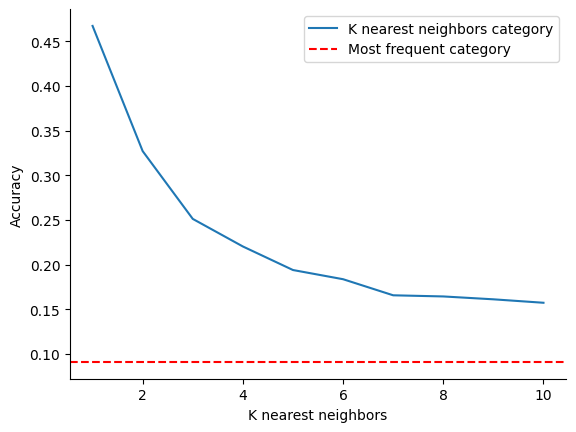

In [105]:
sns.lineplot(data = results, x = 'k', y = 'accuracy',label = 'K nearest neighbors category')
plt.xlabel('K nearest neighbors')
plt.ylabel('Accuracy')
plt.axhline(y = max_accuracy, color = 'red', linestyle = '--',label = 'Most frequent category')
plt.legend()
sns.despine()
plt.savefig('notebooks/figs/k_nearest_neighbors.pdf',dpi = 500, bbox_inches = 'tight')
plt.show()